In [25]:
import numpy as np
import matplotlib.pylab as plt
import pickle
import json
import new_files
import pandas as pd
from os import sep
from scipy.interpolate import interp1d
from matplotlib import colors
import elephant
import neo
import quantities as pq

In [122]:
def csd_compute(surf_tcs, spacing):
    # Compute CSD
    nd=2;

    ex_surf_tcs=np.vstack([surf_tcs[0,:], surf_tcs[0,:], surf_tcs, surf_tcs[-1,:], surf_tcs[-1,:]])
    
    csd=np.zeros((surf_tcs.shape[0], surf_tcs.shape[1]))
    for t in range(surf_tcs.shape[1]):
        phi=ex_surf_tcs[:,t]
        for z in range(surf_tcs.shape[0]):
            csd[z,t]=(phi[(z+2)+nd]-2*phi[(z+2)]+phi[(z+2)-nd])/((nd*spacing)**2)
        
    return csd


def csd_compute_upd(surf_tcs, spacing, nd=2):
    # Compute CSD

    ex_surf_tcs = np.vstack([surf_tcs[0, :], surf_tcs[0, :], surf_tcs, surf_tcs[-1, :], surf_tcs[-1, :]])

    csd = np.zeros((surf_tcs.shape[0], surf_tcs.shape[1]))
    for t in range(surf_tcs.shape[1]):
        phi = ex_surf_tcs[:, t]
        for z in range(surf_tcs.shape[0]):
            csd[z, t] = (phi[(z + 2) + nd] - 2 * phi[z+nd] + phi[(z - 2) + nd]) / ((nd * spacing) ** 2)
        
    return csd


def csd_smooth(csd, layers=11, kind="cubic"):
    layers, time = csd.shape
    smoothed = []
    x = np.linspace(0, 1, num=layers)
    xs = np.linspace(0, 1, num=500)
    for t in range(time):
        fx = interp1d(x, csd[:, t], kind=kind)
        ys = fx(xs)
        smoothed.append(ys)
    smoothed = np.array(smoothed).T
    return smoothed


def plot_spaced_signal(signal, times, ax):
    v_contacts = signal.shape[0]
    cm = plt.colormaps["rainbow"]
    cm_l = cm(np.linspace(0,1, num=v_contacts))[:,:3]
    max_amp = np.abs(signal).max()
    max_amp = max_amp + max_amp*0.05
    spacing = np.linspace(0, max_amp * v_contacts, num=v_contacts)
    vis_signal = signal + spacing.reshape(-1,1)
    for ix, vs in enumerate(vis_signal):
        ax.plot(times, vs, lw=1, c=cm_l[ix])
    ax.set_yticks(spacing)
    ax.set_yticklabels(np.arange(1,v_contacts+1)[::-1])
    ax.set_ylim(spacing[0] - max_amp, spacing[-1] + max_amp)


def plot_csd(smooth_csd, list_ROI_vertices, bb_path, times, ax, cb=True, cmap="RdBu_r", vmin_vmax=None, return_details=False):
    layer_labels = ["I", "II", "III", "IV", "V", "VI"]
    with open(bb_path, "r") as fp:
        bb = json.load(fp)
    bb = [np.array(bb[i])[list_ROI_vertices] for i in bb.keys()]
    bb_mean = [np.mean(i) for i in bb]
    bb_std = [np.std(i) for i in bb]
    max_smooth = np.max(np.abs(smooth_csd))
    if vmin_vmax == None:
        divnorm = colors.TwoSlopeNorm(vmin=-max_smooth, vcenter=0, vmax=max_smooth)
    elif vmin_vmax == "norm":
        divnorm = colors.Normalize()
    else:
        divnorm = colors.TwoSlopeNorm(vmin=vmin_vmax[0], vcenter=0, vmax=vmin_vmax[1])
    extent = [times[0], times[-1], 1, 0]
    csd_imshow = ax.imshow(
        smooth_csd, norm=divnorm, origin="lower",
        aspect="auto", extent=extent,
        cmap=cmap, interpolation="none"
    )
    ax.set_ylim(1,0)
    
    layers_params = []
    for l_ix, th in enumerate(np.cumsum(bb_mean)):
        ax.axhline(th, linestyle=(0, (5,5)), c="black", lw=0.5)
        # ax.axhspan(th-bb_std[l_ix], th+bb_std[l_ix], alpha=0.05, color="black", lw=0)
        ax.annotate(layer_labels[l_ix],[times[0]+0.06, th-0.01], size=15, ha='left')
        layers_params.append([th, layer_labels[l_ix]])
    if cb:
        plt.colorbar(csd_imshow, ax=ax)
    plt.tight_layout()
    if return_details:
        return layers_params, csd_imshow


In [3]:
epoch_types = {
    "visual": [np.linspace(-0.2, 0.8, num=601), [0.0, 0.2], -0.01],
    "motor": [np.linspace(-0.5, 0.5, num=601), [-0.2, 0.2], -0.2]
}

In [4]:
dir_search = new_files.Files()

In [5]:
all_pickles = dir_search.get_files("/scratch/poster_visualisations", "*.pickle")

In [6]:
pickle_file = all_pickles[0]
epoch_type = [i for i in epoch_types.keys() if i in pickle_file.split(sep)[-1]][0]
with (open(pickle_file, "rb")) as file:
    data = pickle.load(file)

json_file = data["json"]
with open(json_file) as pipeline_file:
    info = json.load(pipeline_file)
cortical_thickness = np.load(info["cortical_thickness_path"])
atlas_labels = np.load(info["atlas_labels_path"])
atlas_colours = np.load(info["atlas_colors_path"])
atlas = pd.read_csv(info["atlas"])
results_keys = [i for i in list(data.keys()) if isinstance(i, tuple)]

In [ ]:
# key_keys = [i for i in results_keys if i[1] == "signal"]

# for kk in key_keys:
#     vertex = data[(kk[0], "ROI_vertex")]
#     print(vertex)
#     signal = data[kk]
#     gradient_last = csd_compute(signal, cortical_thickness[vertex]/10)
#     gradient_new_nd_1 = csd_compute_upd(signal, cortical_thickness[vertex]/10, nd=1)
#     gradient_new_nd_2 = csd_compute_upd(signal, cortical_thickness[vertex]/10, nd=2)
#     label = kk[0]
    
#     f, ax = plt.subplots(3,3, figsize=(7, 7))
#     label_list = ["Recent version", "Updated nd=1", "Updated nd=2"]
#     for ix, gradient in enumerate([gradient_last, gradient_new_nd_1, gradient_new_nd_2]):
#         
#         plot_spaced_signal(gradient, epoch_types[epoch_type][0], ax[ix,1])
#         ax[ix,1].set_ylabel(label_list[ix])
#         CSD_res = csd_smooth(gradient)
#         baseline_lim = epoch_types[epoch_type][2]
#         baseline = np.mean(CSD_res[:, np.where(epoch_types[epoch_type][0] < baseline_lim)], axis=2)
#         CSD_res = CSD_res - baseline
#         CSD_res = (CSD_res - CSD_res.mean()) / CSD_res.std()
#         im = plot_csd(
#             CSD_res, [vertex],
#             info["big_brain_layers_path"], 
#             epoch_types[epoch_type][0], ax=ax[ix,2],
#             return_details=True, cb=False
#         )

#     f.suptitle(label)
#     plt.tight_layout()

discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]


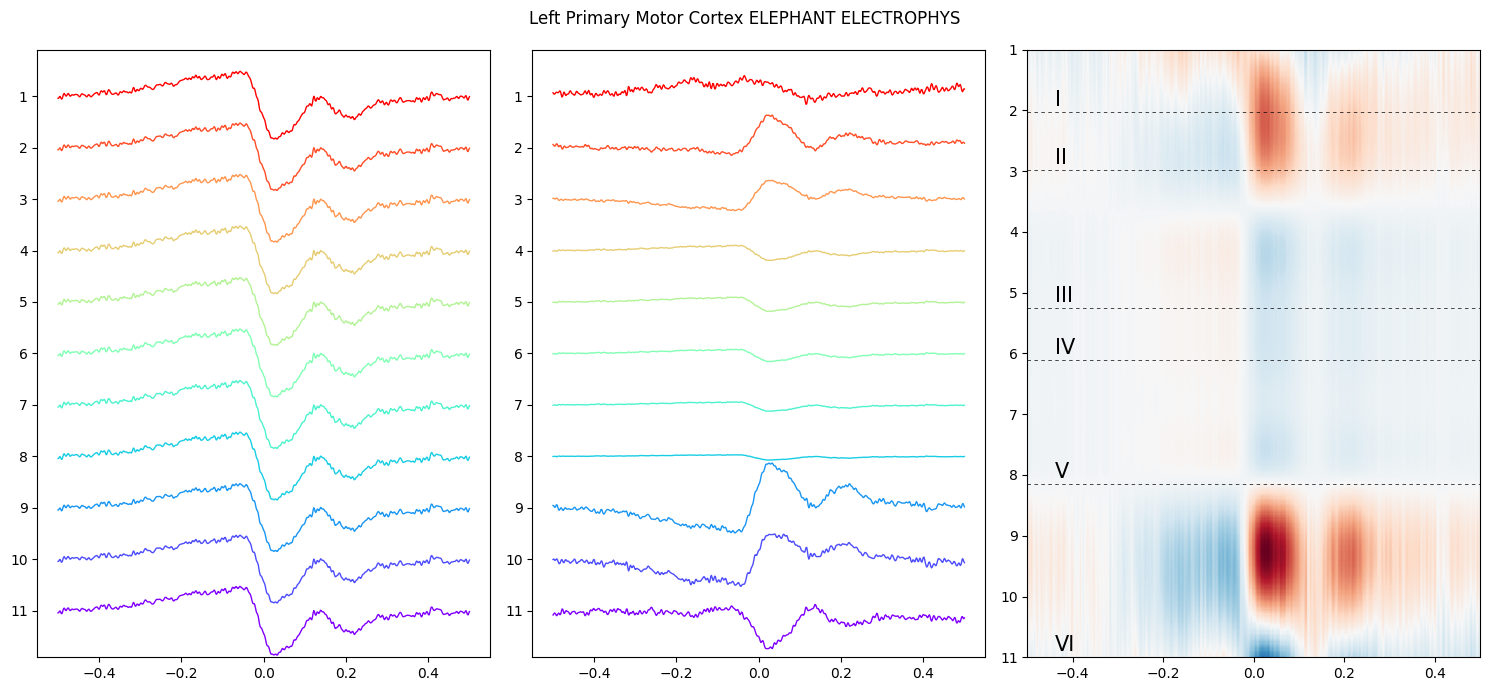

In [139]:
key_keys = [i for i in results_keys if i[1] == "signal"]
kk = key_keys[2]
vertex = data[(kk[0], "ROI_vertex")]
signal = data[kk]

sig = neo.core.AnalogSignal(
    signal.T, units="T", sampling_rate=600*pq.Hz
)
th = pq.Quantity(np.linspace(0, cortical_thickness[vertex], num=11).reshape(-1,1)) * pq.mm
csd_est = elephant.current_source_density.estimate_csd(
    sig, th,
    method = "StandardCSD"
)
gradient = csd_est.as_array().T
times = epoch_types[epoch_type][0]

f, ax = plt.subplots(1, 3, figsize=(15, 7))
plot_spaced_signal(signal, times, ax[0])
plot_spaced_signal(gradient, times, ax[1])

CSD_res = csd_smooth(gradient, kind="cubic")
baseline_lim = epoch_types[epoch_type][2]
baseline = np.mean(CSD_res[:, np.where(epoch_types[epoch_type][0] < baseline_lim)], axis=2)
CSD_res = CSD_res - baseline
CSD_res = (CSD_res - CSD_res.mean()) / CSD_res.std()
im = plot_csd(
    CSD_res, [vertex],
    info["big_brain_layers_path"], 
    epoch_types[epoch_type][0], ax=ax[2],
    return_details=True, cb=False
)

ax[2].set_yticks(np.linspace(0,1, num=11))
ax[2].set_yticklabels(np.arange(1,12));
f.suptitle("{} ELEPHANT ELECTROPHYS".format(kk[0]))
plt.tight_layout()

In [109]:
th = np.linspace(0, cortical_thickness[vertex], num=11)
dist = np.mean(np.diff(th))
th = np.insert(th, 0, th[0]-dist)
th = np.append(th, th[-1]+dist)
aug = np.mean(signal, axis=0)
aug_signal = np.vstack([aug, signal, aug])

In [110]:
aug_signal.shape

(13, 601)

In [ ]:
def csd_calc(signal, thickness, sfreq):
    """
    signal - contact x time
    thickness - overall in mm
    sampling rate - in Hz
    """
    sig = neo.core.AnalogSignal(
        signal.T, units="T", sampling_rate=sfreq*pq.Hz
    )
    th = pq.Quantity(np.linspace(0, cortical_thickness[vertex], num=11).reshape(-1,1)) * pq.mm
    csd_est = elephant.current_source_density.estimate_csd(
        sig, th,
        method = "StandardCSD"
    )
    return csd_est.as_array().T

Text(0.5, 1.0, 'Second Derivative')

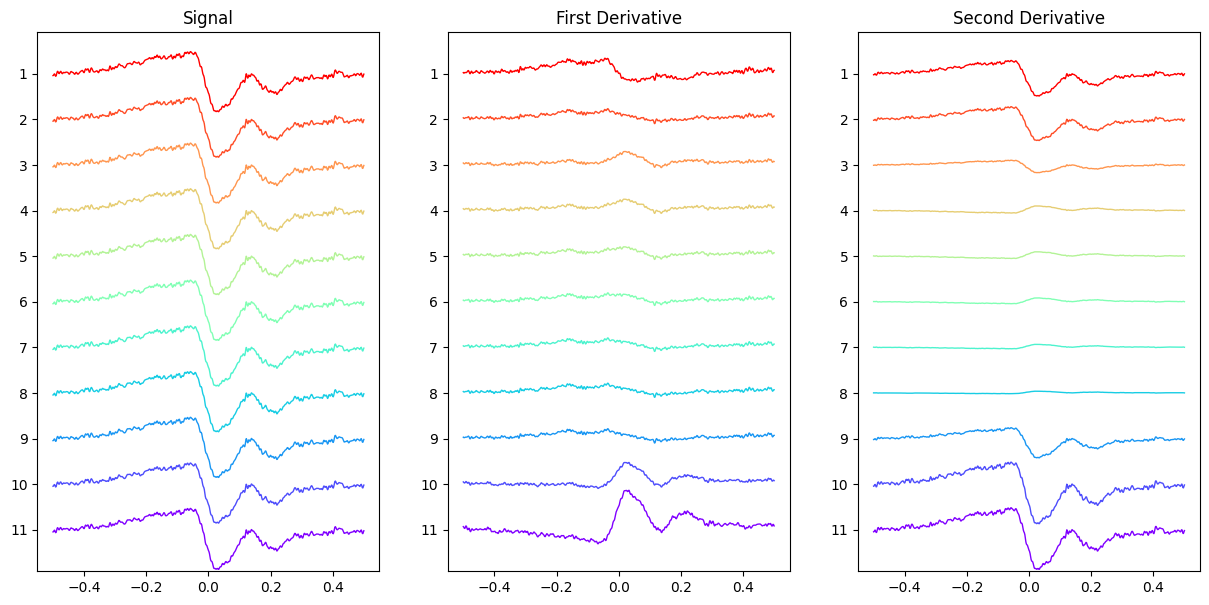

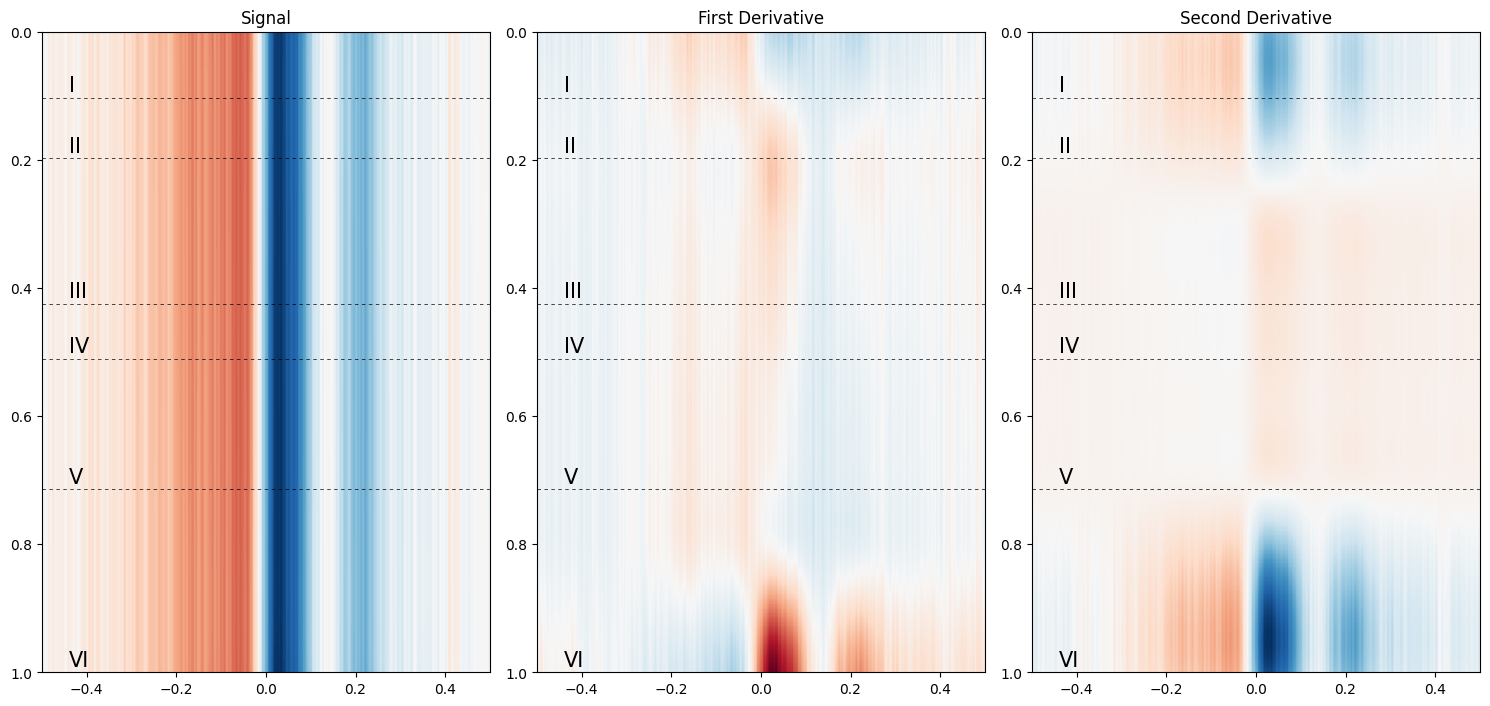

In [147]:
key_keys = [i for i in results_keys if i[1] == "signal"]
kk = key_keys[2]
vertex = data[(kk[0], "ROI_vertex")]
signal = data[kk]
f_dr = np.gradient(signal, axis=0, edge_order=1)
s_dr = np.gradient(f_dr, axis=0, edge_order=1)

times = epoch_types[epoch_type][0]
f, ax = plt.subplots(1, 3, figsize=(15, 7))
plot_spaced_signal(signal, times, ax[0])
plot_spaced_signal(f_dr, times, ax[1])
plot_spaced_signal(s_dr, times, ax[2])
ax[0].set_title("Signal")
ax[1].set_title("First Derivative")
ax[2].set_title("Second Derivative")

f, ax = plt.subplots(1, 3, figsize=(15, 7))

CSD_res = csd_smooth(signal, kind="cubic")
baseline_lim = epoch_types[epoch_type][2]
baseline = np.mean(CSD_res[:, np.where(epoch_types[epoch_type][0] < baseline_lim)], axis=2)
CSD_res = CSD_res - baseline
CSD_res = (CSD_res - CSD_res.mean()) / CSD_res.std()
plot_csd(
    CSD_res, [vertex],
    info["big_brain_layers_path"], 
    epoch_types[epoch_type][0], ax=ax[0],
    return_details=True, cb=False
)

CSD_res = csd_smooth(f_dr, kind="cubic")
baseline_lim = epoch_types[epoch_type][2]
baseline = np.mean(CSD_res[:, np.where(epoch_types[epoch_type][0] < baseline_lim)], axis=2)
CSD_res = CSD_res - baseline
CSD_res = (CSD_res - CSD_res.mean()) / CSD_res.std()
plot_csd(
    CSD_res, [vertex],
    info["big_brain_layers_path"], 
    epoch_types[epoch_type][0], ax=ax[1],
    return_details=True, cb=False
)

CSD_res = csd_smooth(s_dr, kind="cubic")
baseline_lim = epoch_types[epoch_type][2]
baseline = np.mean(CSD_res[:, np.where(epoch_types[epoch_type][0] < baseline_lim)], axis=2)
CSD_res = CSD_res - baseline
CSD_res = (CSD_res - CSD_res.mean()) / CSD_res.std()
plot_csd(
    CSD_res, [vertex],
    info["big_brain_layers_path"], 
    epoch_types[epoch_type][0], ax=ax[2],
    return_details=True, cb=False
)

ax[0].set_title("Signal")
ax[1].set_title("First Derivative")
ax[2].set_title("Second Derivative")